In [28]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error as mae

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("mauna_loa.csv")
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [3]:
df['ppm_fixed'] = df['ppm'].map(lambda x: np.nan if x < 0 else x).fillna(method='backfill')

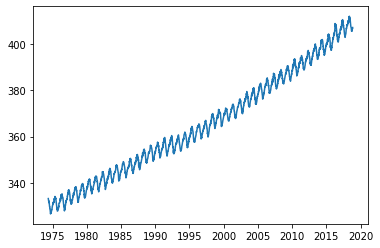

In [5]:
plt.plot(df.date, df.ppm_fixed);

In [8]:
train = df[df.year < 2010]
test = df[df.year >= 2010]

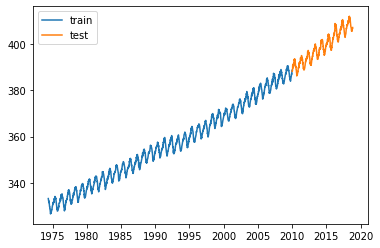

In [9]:
plt.plot(train.date, train.ppm_fixed, label="train");
plt.plot(test.date, test.ppm_fixed, label="test");
plt.legend();

## Prophet

In [11]:
fb_df = train[['date', 'ppm_fixed']].copy()
fb_df.columns = ['ds', 'y']

In [12]:
m = Prophet()
m.fit(fb_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
len(test)

462

In [14]:
future = m.make_future_dataframe(periods=len(test), freq='W', include_history=False)
future.head()

,ds
0,2010-01-03
1,2010-01-10
2,2010-01-17
3,2010-01-24
4,2010-01-31


In [15]:
future.tail()

,ds
457,2018-10-07
458,2018-10-14
459,2018-10-21
460,2018-10-28
461,2018-11-04


In [16]:
test.tail()

,year,month,day,decimal,ppm,#days,1 yr ago,10 yr ago,since 1800,date,ppm_fixed
2316,2018,10,7,2018.7658,405.58,7,403.38,382.78,129.25,2018-10-07,405.58
2317,2018,10,14,2018.7849,406.00,6,403.81,382.92,129.45,2018-10-14,406.00
2318,2018,10,21,2018.8041,406.62,7,404.04,383.04,129.77,2018-10-21,406.62
2319,2018,10,28,2018.8233,406.48,6,404.07,383.96,129.29,2018-10-28,406.48
2320,2018,11,4,2018.8425,406.99,5,404.26,383.80,129.43,2018-11-04,406.99


In [17]:
forecast = m.predict(future)

In [18]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-03,388.641156,387.967268,388.986579,388.641156,388.641156,-0.172904,-0.172904,-0.172904,-0.172904,-0.172904,-0.172904,0.0,0.0,0.0,388.468252
1,2010-01-10,388.679144,388.137575,389.175013,388.679144,388.679144,0.020884,0.020884,0.020884,0.020884,0.020884,0.020884,0.0,0.0,0.0,388.700029
2,2010-01-17,388.717133,388.361884,389.460273,388.717133,388.717133,0.204730,0.204730,0.204730,0.204730,0.204730,0.204730,0.0,0.0,0.0,388.921863
3,2010-01-24,388.755121,388.627717,389.657825,388.755121,388.755121,0.366814,0.366814,0.366814,0.366814,0.366814,0.366814,0.0,0.0,0.0,389.121935
4,2010-01-31,388.793109,388.772105,389.836652,388.793109,388.793109,0.503869,0.503869,0.503869,0.503869,0.503869,0.503869,0.0,0.0,0.0,389.296978


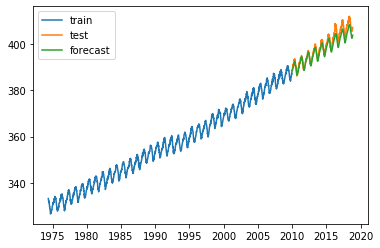

In [19]:
plt.plot(train.date, train.ppm_fixed, label="train");
plt.plot(test.date, test.ppm_fixed, label="test");
plt.plot(test.date, forecast.yhat, label="forecast");
plt.legend();

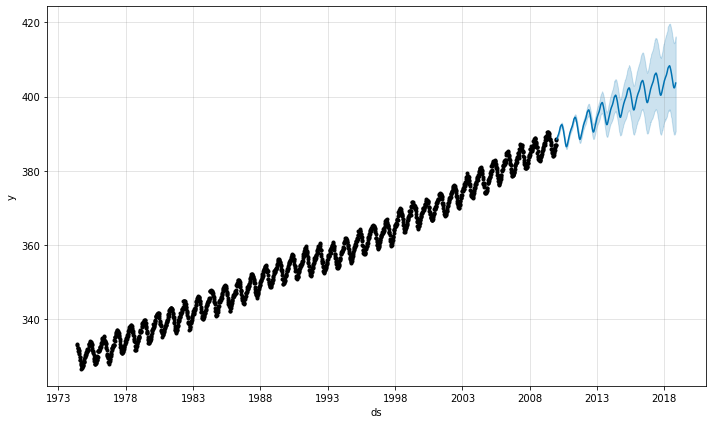

In [21]:
m.plot(forecast);

In [22]:
def linear_func(data, k=None, b=0):
    mean_value = np.mean(data)
    if k is None:
        return [mean_value] * len(data)
    
    return [idx*k + b for idx,_ in enumerate(data)]

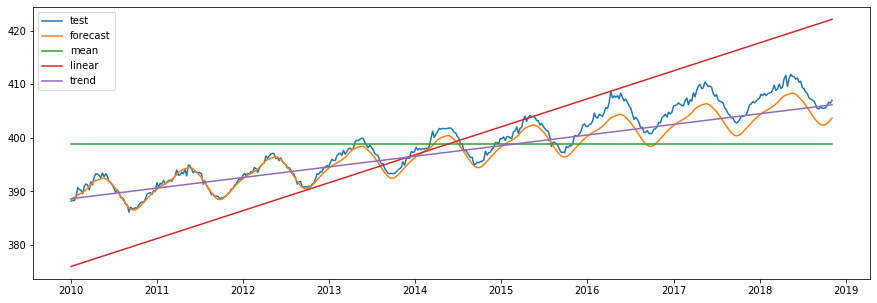

In [38]:
plt.figure(figsize=(15, 5))
plt.plot(test.date, test.ppm_fixed, label="test");
plt.plot(test.date, forecast.yhat, label="forecast");
plt.plot(test.date, linear_func(test.ppm_fixed), label="mean")
plt.plot(test.date, linear_func(test.ppm_fixed, 0.1, 376), label="linear")
plt.plot(test.date, forecast.trend, label="trend")
plt.legend();

In [39]:
print('mean', mae(test.ppm_fixed, linear_func(test.ppm_fixed)))
print('linear', mae(test.ppm_fixed, linear_func(test.ppm_fixed, 0.1, 376)))
print('trend', mae(test.ppm_fixed, forecast.trend))
print('forecast', mae(test.ppm_fixed, forecast.yhat))

mean 5.545033263994318
linear 6.518658008658011
trend 2.388639558554174
forecast 1.46864643676106


In [34]:
best_k = 0.2
best_b = 300
best_mae = mae(test.ppm_fixed, linear_func(test.ppm_fixed, best_k, best_b))

for k in np.linspace(0.1, 1.0, 10):
    for b in range(0, 400):
        actual = mae(test.ppm_fixed, linear_func(test.ppm_fixed, k, b))
        if actual < best_mae:
            best_mae = actual
            best_k = k
            best_b = b
            
print("Best mea={} for k={} and b={}".format(best_mae, best_k, best_b))

Best mea=6.518658008658011 for k=0.1 and b=376
